In [13]:
import numpy as np 
import scipy as sp
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql


In [3]:
# assets = ["CL=F", "GC=F!","NG=F"]
# data = yf.download(assets, start="2015-02-01")["Adj Close"]

In [4]:
assets = {
    "Oil": "CL=F",
    "Gold": "GC=F",
    "Gas": "NG=F"
}

price_data = {}

for name, ticker in assets.items():
    try:
        df = yf.download(
            ticker,
            start="2015-02-01",
            auto_adjust=False, # controls whether yahoo auto matically adjusts prices for dividends/splits
            progress=False # dosent show progress bar
        )
        price_data[name] = df["Close"].iloc[:, 0] # selecting just the first close column # taking the closing column of the dataframe working with the settlement price of each day
    except Exception as e: # put this in incase of any error the loop will keep running
        print(f"Failed to download {name}: {e}")

prices = pd.DataFrame(price_data).dropna()



In [5]:
print(prices)

                  Oil         Gold    Gas
Date                                     
2015-02-02  49.570000  1276.199951  2.680
2015-02-03  53.049999  1259.699951  2.754
2015-02-04  48.450001  1263.800049  2.662
2015-02-05  50.480000  1262.000000  2.600
2015-02-06  51.689999  1233.900024  2.579
...               ...          ...    ...
2026-01-27  62.389999  5079.899902  6.954
2026-01-28  63.209999  5301.600098  7.460
2026-01-29  65.419998  5318.399902  3.918
2026-01-30  65.209999  4713.899902  4.354
2026-02-02  61.990002  4783.600098  3.651

[2766 rows x 3 columns]


# Will use two models Geometric Brownian Motion and Mean-Reverting Model

## Geometric Brownian Motion (GBM)

### $ds$ = $\mu S dt + \sigma S dW$

$\mu$ = drift

$\sigma$ = volatility

Continuous-time stochastic process in whch the logarithm of a randomly varying quantity follows Brownian motion with drift. 

## Mean-Reverting Model

### $dX$ = $\theta(\nu - X)dt + \sigma dW$


Model assumes the assets price will tend to converge to the average price over time.

### Will use these models in a Monte Carlo Simulation Engine

In [6]:
##### Geometric Brownian Model #######

def estimate_gbm_parameters(prices, trading_days = 252):
    '''
    prices = pandas series(Oil, Gold, Gas)

    Estimate drift and volatility for a GBM model using historical price data
    '''

    log_returns = np.log(prices / prices.shift(1)).dropna() # log of how the price changes multiplicatively each day

    mu = log_returns.mean() * trading_days # average daily returns scaled to yearly
    sigma = log_returns.std() * np.sqrt(trading_days) # daily volatility scaled to annual volatility
    #(it is the sqrt of trading days as standard deviation is not linear)

    return mu, sigma


def gbm_simulation(S0, mu, sigma, T = 1.0, steps = 252, n_sims = 1000, random_seed = None):
    '''
    S0 = starting price, this is the anchor for all the simualted paths 
    mu = drift, average rate of change in a stochastic variable (like a stock price or interest rate) per unit of time
    sigma =  volatility
    T / steps = size of each time step

    Simulate price paths using GBM model
    '''

    if random_seed is not None:
        np.random.seed(random_seed)

    dt = T / steps
    paths = np.zeros((steps + 1, n_sims),dtype = float) # rows is time, columns is simulated futures
    paths[0] = S0 # start simulation at known price
 
    #so it starts from the most recent price - using parameters estimated by historical data - applys expected growth and random impluses - now uses that as new most recent value and so on
 
    for t in range(1, steps+1):

        #Z is how many paths we will get each time Z generate n_sims number of impulses they get added indepentdently to a seperate path each time 
        Z = np.random.standard_normal(n_sims) # produce random gaussian impulses as a kind of market surprise
        # print(Z)
        paths[t]= paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z) # maths for this is to do with the fact we need to convert the equatin above to log space and use the brownian properties
        
        
    # what this equation is doing is taking the last price applying expected growth and random impulses
    
        return paths

In [11]:
oil_prices = prices['Oil']
mu_oil, sigma_oil = estimate_gbm_parameters(oil_prices)

simulated_paths = gbm_simulation(
    oil_prices.iloc[-1], # want the most recent price
    mu_oil,
    sigma_oil,
    T = 1,
    steps = 252,
    n_sims = 10000,
    random_seed = 42)

print(oil_prices.iloc[-1])

61.9900016784668


In [8]:
# plt.figure(figsize=(10,5))
# plt.plot(simulated_paths[:,0])
# plt.title("Monte Carlo Simulation of Oil Prices")
# plt.xlabel("Time Steps")
# plt.ylabel("Price")
# plt.show()

#could be going to zero because of the random impulse, its sending to zero 
#paths isnt getting updated after the first few runs

In [9]:
# simulated_paths

# Performing the same analysis using QuantLib

In [17]:
# still need values from previous code 
#S0 = starting point for simulation, mu = simulation expected growth, sigma = magnitude of randomness, r = risk free rate
S0 = float(oil_prices.iloc[-1])
mu_oil, sigma_oil = estimate_gbm_parameters(oil_prices)
r = 0.02

calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

today = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = today

maturity = today + ql.Period(1, ql.Years)


c:\Users\maxro\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
risk_free_curve = ql.FlatForward(today, r, day_count)
dividend_curve = ql.FlatForward(today, 0.0, day_count)

#changing to a term-structure
risk_free_ts = ql.YieldTermStructureHandle(risk_free_curve)
dividend_ts = ql.YieldTermStructureHandle(dividend_curve)

In [19]:
#assume volitility is constant
vol_surface = ql.BlackConstantVol(today,ql.NullCalendar(),sigma_oil, day_count)

vol_ts = ql.BlackVolTermStructureHandle(vol_surface)

In [20]:
# this represents the equation for gbm above 
gbm_model = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(S0)),dividend_ts, risk_free_ts, vol_ts)

In [ ]:
time_steps= 252 # number of trading days
n_sims = 5000 # number of simulated paths
seed = 42

#make a time-grid in years
time_grid = ql.TimeGrid(day_count.yearFraction(today, maturity), time_steps)

#turns uniform random numbers into Gaussian shocks
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(time_steps, ql.UniformRandomGenerator(42)))

# creates the paths by applying the gbm model
path_generator = ql.GaussianPathGenerator(gbm_model, time_grid, rng, False)

In [25]:
paths = np.zeros((n_sims, time_steps+1)) # setting up a grid of zeros to save paths to#

for i in range(n_sims):
    sample_path = path_generator.next().value()
    paths[i,:] = [sample_path[j] for j in range(len(sample_path))]

In [ ]:
paths.shape # each row should be one simulated future possibility 

(5000, 253)

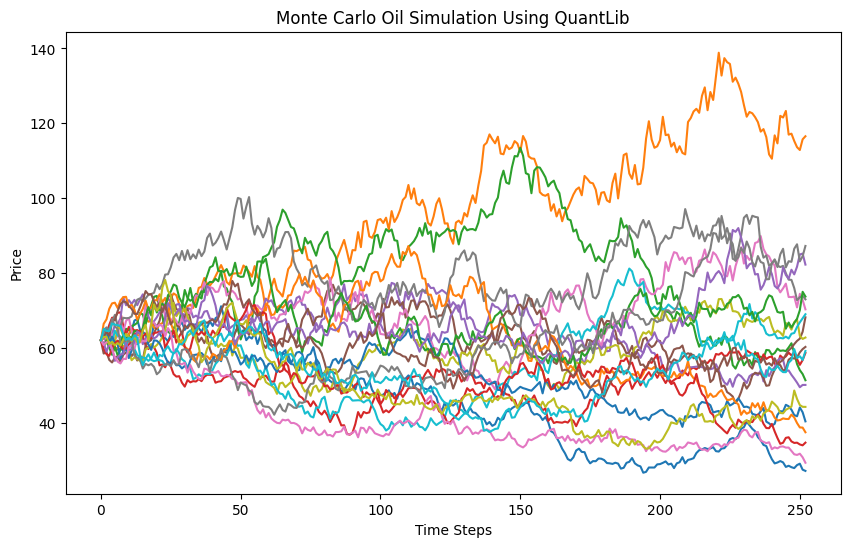

In [28]:
plt.figure(figsize = (10,6))

for i in range(20):
    plt.plot(paths[i])

plt.title("Monte Carlo Oil Simulation Using QuantLib")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()